# Derivatives, HA2
# Prepared by Said Magomedov, MFE221

## Problem 3. Part c

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

#### Model Setup

In [2]:
S0 = 100 # initial stock price
v0 = 0.01 # initial variance
theta = 0.01 # variance mean level
kappa = 2 # strength of mean reversion
sigma = 0.225 # vol of vol
r = 0 # risk-free rate
lam = 0 # lambda mean level
T = 0.5 # time to maturity
steps = 150 # number of time steps
dt = T / steps # one time step
N = 10000 # number of simulations


def heston_mc(K, rho, sigma=0.225):
    global v, S
    S = np.ones((steps + 1, N))
    v = np.ones((steps + 1, N))
    S[0, :] = S0
    v[0, :] = v0
    
    # I generate two correlated standard normal random variables and then convert them to BM
    # by multiplying them by sqrt(dt)
    Z1 = np.random.normal(size=(steps, N))
    Z2 = rho * Z1 + np.sqrt(1 - rho ** 2) * np.random.normal(size=(steps, N))
    
    for t in range(1, steps + 1):
        drift = r * S[t - 1, :]
        vol = np.sqrt(v[t - 1, :])
        S[t, :] = S[t - 1, :] * np.exp((drift - 0.5 * vol ** 2) * dt + vol * np.sqrt(dt) * Z1[t - 1, :])
        v[t, :] = np.maximum(v[t - 1, :] + kappa * (theta - v[t - 1, :]) * dt + 
                             sigma * np.sqrt(v[t - 1, :]) * np.sqrt(dt) * Z2[t - 1, :], 0)
        
    # option's payoff at time T
    payoff = np.maximum(S[-1, :] - K, 0)
    
    # discount them and take the average
    option_price = np.exp(-r * T) * payoff
    
    return np.mean(option_price)

#### Calculate option prices for different values of K and $\rho$ by realizing the defined function

In [3]:
# let's fix the random sample generated for each iteration in our for loop
np.random.seed(56)

Ks = [70, 80, 90, 100, 110, 120, 130]
rhos = [-0.5, 0, 0.5]
priceTable = pd.DataFrame()

for K in Ks:
    for rho in rhos: 
        priceTable.at[rho, K] = heston_mc(K, rho)
display(priceTable)

,70,80,90,100,110,120,130
-0.5,29.854058,19.972857,10.411090,2.641012,0.135096,0.005350,0.000389
0.0,30.034403,20.046145,10.215937,2.739509,0.319840,0.042429,0.006474
0.5,29.975390,20.030633,10.221985,2.723116,0.542979,0.133583,0.017501


#### Function for extracting obtained values depending on K and $\rho$. Actually those will be the simulated market prices of the option

In [4]:
def C_market(K, rho):
    try:
        return priceTable.at[rho, K]
    except Exception:
        return None

#### Calculation of implied volatilities

In [9]:
# let's compute the implied volatilities
# first, we need to compute the theoretical Black-Scholes price of the option
f = norm.pdf
F = norm.cdf

def bs_call(K, vol):
    d1 = (np.log(S0 / K) + (r + vol ** 2 / 2) * T) / (vol * np.sqrt(T))
    d2 = d1 - vol * np.sqrt(T)
    C0 = S0 * F(d1) - F(d2) * K * np.exp(-r * T)
    return C0

def vega(K, vol):
    d1 = (np.log(S0 / K) + (r + vol ** 2 / 2) * T) / (vol * np.sqrt(T))
    vega = S0 * f(d1) * np.sqrt(T) 
    return vega

# second, we do the cailibration 

def iv(K, rho, debug=True):
    tol = 0.0001
    epsilon = 1
    count = 0
    max_iter = 1000

    vol = 0.1

    while epsilon > tol:
        count += count
        if count >= max_iter:
            print('Breaking on count')
            break;
        orig_vol = vol 
        diff = bs_call(K, vol) - C_market(K, rho)
        vol = vol - diff / vega(K, vol)
        epsilon = abs((vol - orig_vol) / vol)

    return vol

#### Generating and saving the implied volatilities using previously defined function iv(K, $\rho$)

In [6]:
ivs1 = [] # ivs for rho = -0.5
ivs2 = [] # ivs for rho = 0
ivs3 = [] # ivs for rho = 0.5

for K in Ks:
    ivs1.append(iv(K, -0.5))
    ivs2.append(iv(K, 0))
    ivs3.append(iv(K, 0.5))

#### Plot the implied volatilities for different values of $\rho$ against strikes

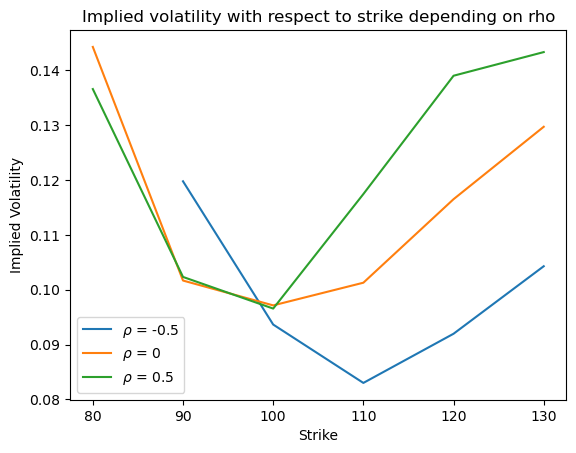

In [7]:
plt.plot(Ks, ivs1, label=r'$\rho$ = -0.5')
plt.plot(Ks, ivs2, label=r'$\rho$ = 0')
plt.plot(Ks, ivs3, label=r'$\rho$ = 0.5')
plt.ylabel("Implied Volatility")
plt.xlabel("Strike")
plt.title("Implied volatility with respect to strike depending on rho")
plt.legend()
plt.show()

#### $\rho$ = 0, list of K remains the same, $\sigma$ = 0.1 or 0.2.

In [17]:
np.random.seed(56)
sigmas = [0.1, 0.2]
priceTableNew = pd.DataFrame()
for K in Ks:
    for sigma in sigmas: 
        priceTableNew.at[sigma, K] = heston_mc(K, 0, sigma)
display(priceTableNew)

def C_market(K, rho):
    try:
        return priceTableNew.at[rho, K]
    except Exception:
        return None

,70,80,90,100,110,120,130
0.1,29.830980,19.998141,10.273408,2.818322,0.334453,0.016016,0.002492
0.2,30.030457,19.945532,10.257243,2.682899,0.336287,0.039625,0.001698


#### Next, we consider our argument $\rho$ in the iv(K, $\rho$) function as $\sigma$. It will not ruin the underlying logic but we will not need to define another function. 

In [18]:
ivs1New = []
ivs2New = []
for K in Ks:
    ivs1New.append(iv(K, 0.1))
    ivs2New.append(iv(K, 0.2))

#### Plot the implied volatilities for different values of $\sigma$ against strikes

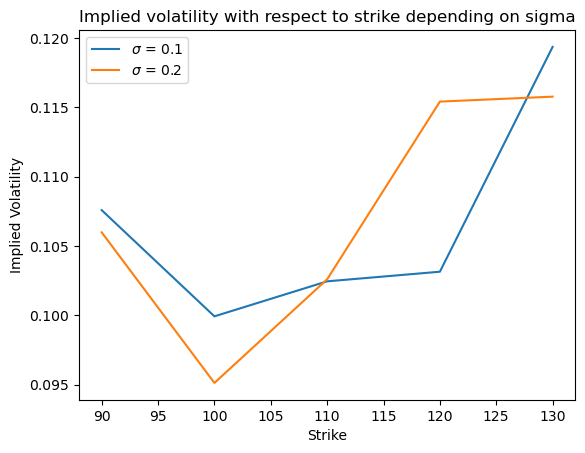

In [19]:
plt.plot(Ks, ivs1New, label=r'$\sigma$ = 0.1')
plt.plot(Ks, ivs2New, label=r'$\sigma$ = 0.2')
plt.ylabel('Implied Volatility')
plt.xlabel('Strike')
plt.title('Implied volatility with respect to strike depending on sigma')
plt.legend()
plt.show()